# Workalong & Exercise: Multidimensional Arrays

In this exercise, we will apply the principles of using multidimensional arrays to estimate global mean temperature from a gridded dataset, accounting for the fact that grid cells become smaller at the poles.  The first part of the exercise is a workalong that introduces `xarray`.

In a dataset with evenly spaced latitude and longitude values, the meridians converge at the poles, making the cells smaller.  The area of the cells is proportional to the cosine of the latitude $\theta$ (in radians):

$$ \Delta A = R_{\oplus}^2 \Delta \theta \Delta \phi \cdot \cos(\theta) $$
$$ \Delta A \propto \cos(\theta)$$

Therefore, when calculating the global average of a quantity (like temperature), the values need to be weighted by $\cos(\theta)$.

**Goal**: correctly calculate a timeseries of global mean temperature from the dataset below

Instructions:

1. execute the cell below to download the dataset (this is the one we used to make sound in the first class)
1. the cell includes code to extract the latitude values (in degrees; `lat`) and the temperature field `temp_3d` as numpy arrays
1. calculate and plot a timeseries of global mean temperature, using the $cos(\theta)$ weighting

In [13]:
import numpy as np
import matplotlib.pyplot as plt


In [1]:
""" Read in the data """
import os
import xarray as xr

# set the year we want to download
year = 2025 

# determine if we are on a UITS system through checking if the file exists in one of two expected places
path1 = f"/N/project/obrienta_startup/regcm_input_data/NNRP1/mirror/surface/air.sig995.{year}.nc"
path2 = f"/N/project/easg690/data/NNRP1/mirror/surface/air.sig995.{year}.nc"
have_local_file = False
local_path = ""
for path in [path1, path2]:
    # check if the file exists and is readable
    if os.path.exists(path) and os.access(path, os.R_OK):
        have_local_file = True
        local_path = path
        print(f"Using local file: {local_path}")
        break

# use the local file if possible
if have_local_file:
    output_file = local_path
# otherwise download the file from the NOAA server
else:
    # set the URL for the NCEP/DOE Reanalysis 2 data file
    url = f"https://psl.noaa.gov/thredds/fileServer/Datasets/ncep.reanalysis/surface/air.sig995.{year}.nc"

    # set the name of the file we want to download to
    output_file = f"air.sig995.{year}.nc"

    # download the data file
    # NOTE: the use of ! at the beginning of the line indicates that this is a shell command, not python code -- though it does use some python code.  How, why?
    # check first if the file exists; don't re-download if it does
    if not os.path.exists(output_file):
        ! curl --output {output_file} {url}

    # (a side note for anyone familiar with xarray: you might ask why I don't use xarray to directly open the file from the URL (or the related OpenDAP URL)?  The reason is that it takes several minutes to open this 55 MB file, whereas directly downloading it takes only a couple seconds!)

# open the dataset using xarray
temp_ds = xr.open_dataset(output_file, chunks = -1)

# get the latitude and temperature values as numpy arrays
lat = temp_ds.lat.values
temp_3d = temp_ds.air.values

# also get the time array
time = temp_ds.time.values

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 15.8M  100 15.8M    0     0  8713k      0  0:00:01  0:00:01 --:--:-- 8713k


sh: getfattr: command not found


In [4]:
# do the exercise here
lat.shape


(73,)

In [5]:
time


array(['2025-01-01T00:00:00.000000000', '2025-01-01T06:00:00.000000000',
       '2025-01-01T12:00:00.000000000', ...,
       '2025-10-01T06:00:00.000000000', '2025-10-01T12:00:00.000000000',
       '2025-10-01T18:00:00.000000000'],
      shape=(1096,), dtype='datetime64[ns]')

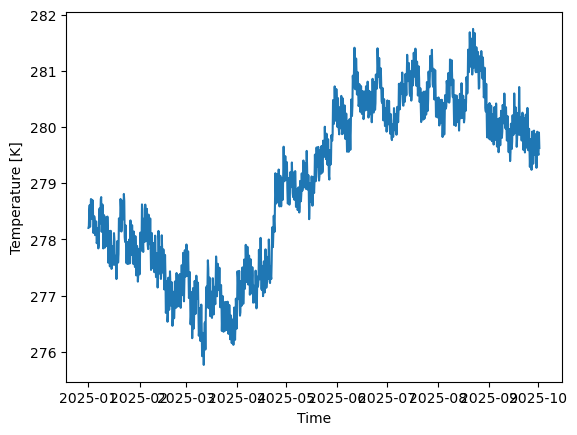

In [14]:
""" Calculate global mean temperature the bad way (unweighted) """
temp_mean = np.mean(temp_3d, axis = (1, 2))
temp_mean

fig, ax = plt.subplots() # create a figure with a single panel (ax)

ax.plot(time, temp_mean)
ax.set_xlabel("Time")
ax.set_ylabel("Temperature [K]")
plt.show() # draw the plot

In [20]:
""" Do the area average the correct way: with weighting """

# Convert lat to radians
lat_rad = np.deg2rad(lat)
#lat_rad

# calculate the cos of the latitude
cos_lat = np.cos(lat_rad)
#cos_lat

# make cos 3D like the air temperature data: make it *conformant*
cos_lat_3d = cos_lat[np.newaxis, :, np.newaxis] * np.ones(temp_3d.shape)
cos_lat_3d.shape

# calculate the weighted sum of temperature
temp_wgt_sum = np.sum(temp_3d * cos_lat_3d, axis = (1,2))
#temp_wgt_sum

# dividi by the sum of the wights
temp_wgt_mean = temp_wgt_sum / np.sum(cos_lat_3d, axis = (1, 2))
temp_wgt_mean

array([286.29520706, 286.27353703, 286.8225563 , ..., 288.37231957,
       288.90123901, 288.64036981], shape=(1096,))